In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sqlite3
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
df_raw = pd.read_csv("temp/lender_checkpoint_1.csv")
df_raw.head(2)

,Deal ID,Lender ID,Zip,City,State,Multifamily Subtype,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,Maturity Date,UPB,Amort DSvc,Orig Amort,IO Period
0,14454.0,19.0,92626,Costa Mesa,CA,Garden,1990,24.0,"1,720,000",5.8%,180.0,"3,500,000",2/1/19,"28,379","14,292",180.0,0.0
1,20421.0,19.0,91406,Los Angeles,CA,Garden,1962,15.0,"500,000",5.3%,180.0,"1,525,000",12/1/19,"46,916","4,022",180.0,0.0


In [3]:
df_cleaned = pd.read_csv("temp/lender_checkpoint_23.csv")
df_cleaned.head(2)

,Lender ID,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,lat,lng,MF_Age Restricted,...,MF_MHC Age Restricted,MF_MHC Co-Op,MF_Manufactured Housing,MF_Mid Rise,MF_Military,MF_Other,MF_Senior,MF_Student,MF_Townhome,MF_Various
0,19,1990.0,24.0,1720000,5.8,180.0,3500000,33.641216,-117.918822,0,...,0,0,0,0,0,0,0,0,0,0
1,19,1962.0,15.0,500000,5.3,180.0,1525000,34.052234,-118.243685,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Cost of capital

Find out which variables correlate with higher interest rates (`Note Rate` column)

In [4]:
# Merge raw and cleaned datasets
df = df_cleaned.merge(
    df_raw[['Maturity Date', 'UPB', 'Amort DSvc', 'Orig Amort', 'IO Period', 'Multifamily Subtype']], 
    left_index=True, right_index=True
)
df.head()

,Lender ID,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,lat,lng,MF_Age Restricted,...,MF_Senior,MF_Student,MF_Townhome,MF_Various,Maturity Date,UPB,Amort DSvc,Orig Amort,IO Period,Multifamily Subtype
0,19,1990.0,24.0,1720000,5.8,180.0,3500000,33.641216,-117.918822,0,...,0,0,0,0,2/1/19,"28,379","14,292",180.0,0.0,Garden
1,19,1962.0,15.0,500000,5.3,180.0,1525000,34.052234,-118.243685,0,...,0,0,0,0,12/1/19,"46,916","4,022",180.0,0.0,Garden
2,50,2009.0,164.0,250000,6.9,120.0,4187586,29.951066,-90.071532,0,...,0,0,0,0,1/1/21,"67,161","2,892",120.0,0.0,Garden
3,19,1957.0,11.0,805000,5.2,180.0,2450000,34.090009,-118.361744,0,...,0,0,0,0,8/1/20,"123,314","6,450",180.0,0.0,Garden
4,51,2002.0,13.0,1600000,6.5,120.0,3112000,40.678178,-73.944158,0,...,0,0,0,0,7/1/19,"124,669","18,200",120.0,0.0,Garden


In [5]:
df.dtypes

Lender ID                    int64
Built                      float64
Units                      float64
Original Loan                int64
Note Rate                  float64
Loan Term (Original)       float64
Appraised Value              int64
lat                        float64
lng                        float64
MF_Age Restricted            int64
MF_Assisted Living           int64
MF_Co-Op                     int64
MF_Co-op                     int64
MF_Corporate                 int64
MF_Garden                    int64
MF_High Rise                 int64
MF_High rise                 int64
MF_Independent Living        int64
MF_Low Rise                  int64
MF_MHC Age Restricted        int64
MF_MHC Co-Op                 int64
MF_Manufactured Housing      int64
MF_Mid Rise                  int64
MF_Military                  int64
MF_Other                     int64
MF_Senior                    int64
MF_Student                   int64
MF_Townhome                  int64
MF_Various          

### 5.1. Clean up new columns

In [6]:
# Convert Maturity Date to datetime
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], infer_datetime_format=True)

# Create new features
df['number of dates till maturity'] = (df['Maturity Date'] - pd.to_datetime('now')).dt.days
df['maturity year'] = df['Maturity Date'].dt.year
df['maturity month'] = df['Maturity Date'].dt.month
# df['maturity day'] = df['Maturity Date'].dt.day

In [7]:
# Convert UPB and Amort DSvc to numeric
df['UPB'] = df['UPB'].str.replace(",", "").astype(int)
df['Amort DSvc'] = df['Amort DSvc'].str.replace(",", "").astype(int)

### 5.2. Visualize relationships between interest rate and other features

#### Numerical features

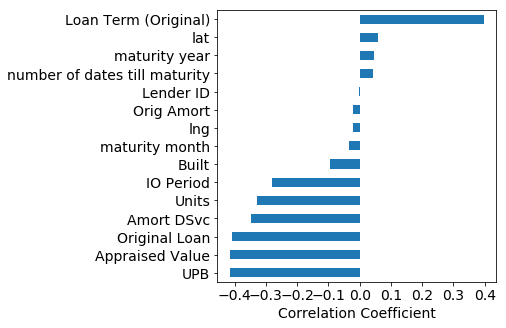

In [8]:
# Correlation coefficient (numerical features only)
columns_for_corr = [col for col in df.columns if "MF" not in col]
df[columns_for_corr].corr(method="spearman")['Note Rate']\
.drop(['Note Rate']).sort_values().plot.barh(figsize=(5,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=14);

From the correlation coeeficient comaprison, it appears that loan term linearly correlate with higher interest rate, which makes sense. Note that correlation coefficient is only able to examine the strength of linear relationship, and it is likely that there are nonlinear correlation between interest rate and other variables.

#### Categorical features

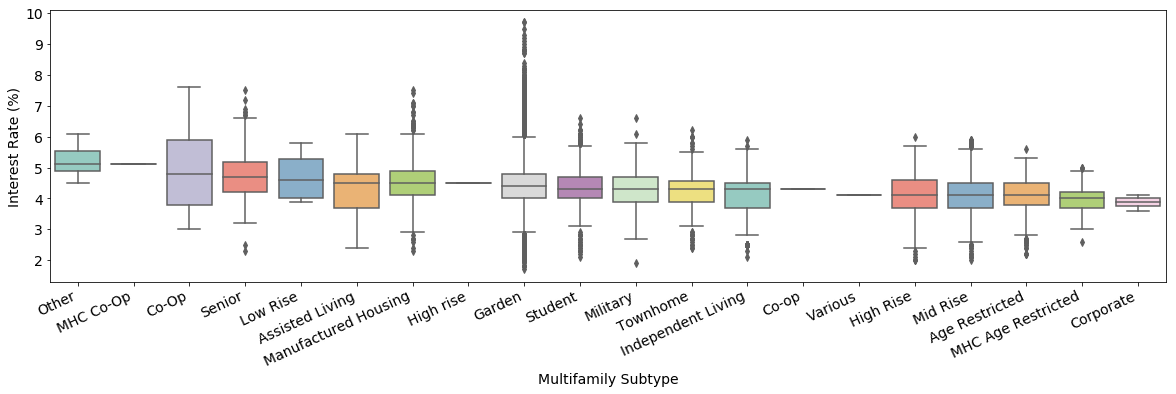

In [9]:
# Multifamily type vs. interest rate
hue_order = df.groupby(['Multifamily Subtype'])['Note Rate'].median().sort_values(ascending=False).index

# Boxplot
fig = plt.figure(figsize = (20, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="Multifamily Subtype", y="Note Rate", data=df, ax=ax, palette='Set3', order=hue_order)
plt.xticks(fontsize=14, rotation=25, ha='right')
plt.yticks(fontsize=14)
plt.xlabel("Multifamily Subtype", fontsize=14)
plt.ylabel("Interest Rate (%)", fontsize=14);

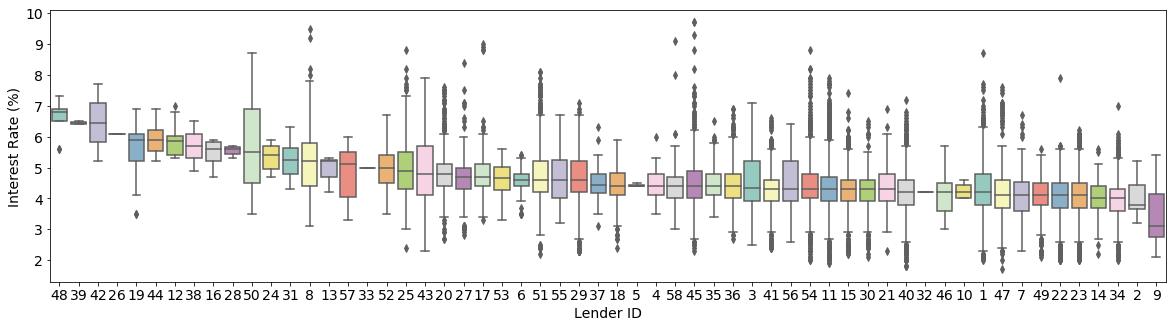

In [10]:
# Lender ID vs. interest rate
hue_order = df.groupby(['Lender ID'])['Note Rate'].median().sort_values(ascending=False).index

# Boxplot
fig = plt.figure(figsize = (20, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="Lender ID", y="Note Rate", data=df, ax=ax, palette='Set3', order=hue_order)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Lender ID", fontsize=14)
plt.ylabel("Interest Rate (%)", fontsize=14);

The boxplots show certain categories of multifamily type and lender correlate with higher interest rate. ANOVA can be used to test the strength of relationship statistically, although for the scope of this project I'm going to proceed without statistical tests.

## 6. Regression model to evaluate most indicative features

Fit a general linear regressor to predict interest rate based on other features. From the trained regressor, features that correlate with higher interest rate can then be inferred.

### 6.1. Prepare data for machine learning

In [11]:
# Drop non-numerical columns
df = df.drop(columns=['Maturity Date', 'Multifamily Subtype'])

In [12]:
# Convert lender ID to dummy columns
df = pd.get_dummies(df, columns=['Lender ID'])

#### Check multicolinearity

In [13]:
# Visualize correlations
def corr_plot(df, num_coln, figsize=(7,7), method='spearman', annot=False):
    
    '''
    Plot correlation coefficient matrix
    
    INPUTS:
    df (DataFrame): dataframe
    num_col (list): list of numerical column names
    
    OUTPUT:
    NONE
    '''

    # sns.set(style="white")
    corr = df[num_coln].corr(method=method)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(
        corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
        xticklabels=num_coln,
        yticklabels=num_coln,
        annot=annot
    )
    plt.xticks(rotation=30, ha='right', fontsize=14) 
    plt.yticks(fontsize=14);
    plt.title(f"{method.title()} Correlation Coefficient", fontsize=14)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)

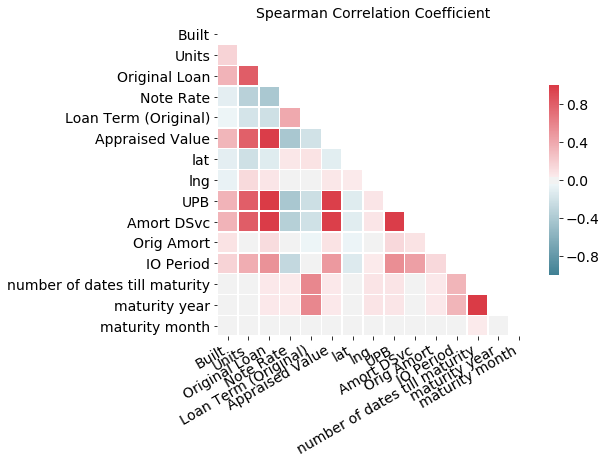

In [14]:
columns_for_corr = [col for col in df.columns if ("MF" not in col) and ("ID" not in col)]
corr_plot(df, columns_for_corr, figsize=(7,7), method='spearman', annot=False)

Columns that have high correlation with others are dropped

In [15]:
# Find features to be removed, i.e. feature that has >0.9 correlation with any remaining feature
corr_abs = df.corr().abs()
cols_to_remove = []
counter = 0
for coln in corr_abs.columns:
    counter += 1
    if corr_abs[coln].iloc[counter:].max() >= 0.9:
        cols_to_remove.append(coln)
print(f"Highly correlated features that should be removed:\n\n{cols_to_remove}\n\n")
cols_to_keep = df.columns.drop(cols_to_remove).tolist()
print(f"Features to keep:\n\n{cols_to_keep}")

Highly correlated features that should be removed:

['Original Loan', 'Appraised Value', 'UPB', 'number of dates till maturity']


Features to keep:

['Built', 'Units', 'Note Rate', 'Loan Term (Original)', 'lat', 'lng', 'MF_Age Restricted', 'MF_Assisted Living', 'MF_Co-Op', 'MF_Co-op', 'MF_Corporate', 'MF_Garden', 'MF_High Rise', 'MF_High rise', 'MF_Independent Living', 'MF_Low Rise', 'MF_MHC Age Restricted', 'MF_MHC Co-Op', 'MF_Manufactured Housing', 'MF_Mid Rise', 'MF_Military', 'MF_Other', 'MF_Senior', 'MF_Student', 'MF_Townhome', 'MF_Various', 'Amort DSvc', 'Orig Amort', 'IO Period', 'maturity year', 'maturity month', 'Lender ID_1', 'Lender ID_2', 'Lender ID_3', 'Lender ID_4', 'Lender ID_5', 'Lender ID_6', 'Lender ID_7', 'Lender ID_8', 'Lender ID_9', 'Lender ID_10', 'Lender ID_11', 'Lender ID_12', 'Lender ID_13', 'Lender ID_14', 'Lender ID_15', 'Lender ID_16', 'Lender ID_17', 'Lender ID_18', 'Lender ID_19', 'Lender ID_20', 'Lender ID_21', 'Lender ID_22', 'Lender ID_23', 'Lender ID_

In [16]:
# Drop the highly correlated features
df = df[cols_to_keep]

Correlations among the remaining features:


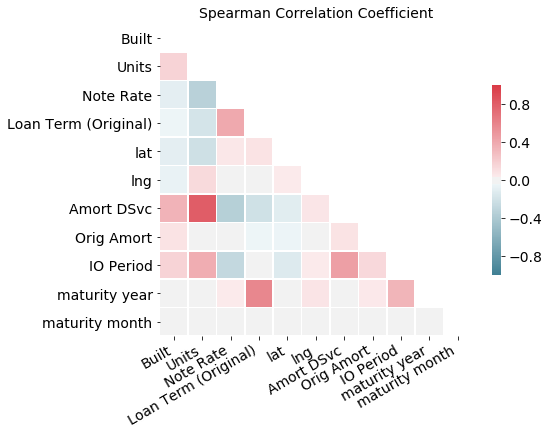

In [17]:
# Visualize correlations of the remaining features
columns_for_corr = [col for col in cols_to_keep if ("MF" not in col) and ("ID" not in col)]
print("Correlations among the remaining features:")
corr_plot(df, columns_for_corr, figsize=(7,7), method='spearman', annot=False);

There aren't extremely strong correlations (correlation coefficient >=0.9) left.

#### Check feature distributions

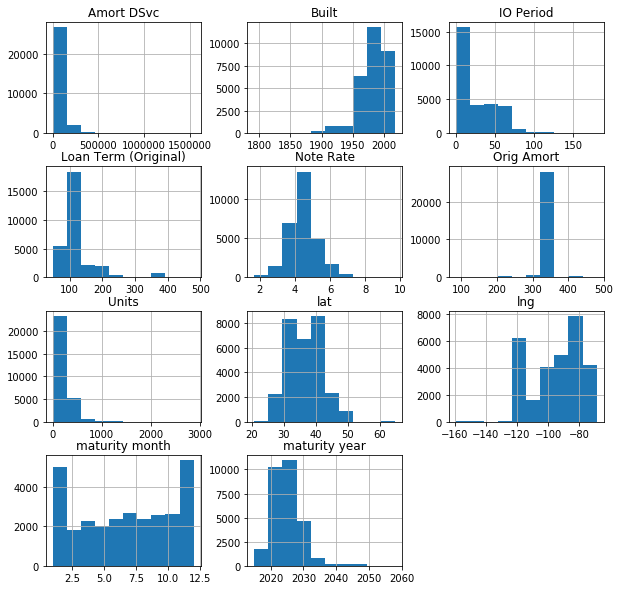

In [18]:
# Examine feature distributions (excluding binary features)
col_names = [col for col in cols_to_keep if ("MF" not in col) and ("ID" not in col)]
df[col_names].hist(figsize=(10,10));

Most of the features are not extremely skewed. Ideally, I would tranform features to have more normal-like distributions. For the current scope, I would use the features as they are.

### 6.2. Prepare training and testing set

#### Train-test split

In [19]:
X = df.drop(columns=["Note Rate"])
y = df['Note Rate']

# Shuffle and split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 23302 samples.
Testing set has 5826 samples.


#### Feature scaling

Apply feature scaling to non-binary features. This helps achieve faster learning.

In [20]:
# Apply feature scaling to the features (excluding binary features)
to_scale = [col for col in X_train.columns if ("MF" not in col) and ("ID" not in col)]

# Rescale features
scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

# # Sanity check
# df[to_scale].hist(figsize=(10,10));

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

### 6.3. Model evaluation

To evaluate model performance, I chose MSE (mean squared error). The square root of MSE will then represents the amount by which the prediction is off.

In [21]:
def model_eval(reg, X_train, y_train, X_test, y_test, print_output=True):
    """
    Evaluate model performance using root mean square error (RMSE)
    INPUTS:
        reg: fitted regressor
        X_train, y_train, X_test, y_test: training and testing sets
    OUTPUTS:
        rmse_train, rmse_test: RMSE of training and testing sets
    """
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
    rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
    
    if print_output:
        print(reg)
        print(f"\nTraining error: {rmse_train}")
        print(f"Testing error: {rmse_test}")
        
    return rmse_train, rmse_test

In [22]:
# Linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
rmse_train, rmse_test = model_eval(reg, X_train, y_train, X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Training error: 0.6356404543761386
Testing error: 36445894157.873024


In [23]:
# Ridge
reg = Ridge(random_state=42)
reg.fit(X_train, y_train)
rmse_train, rmse_test = model_eval(reg, X_train, y_train, X_test, y_test)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

Training error: 0.6345978593317426
Testing error: 0.6385371491662181


In [24]:
# Lasso
reg = Lasso(random_state=42)
reg.fit(X_train, y_train)
rmse_train, rmse_test = model_eval(reg, X_train, y_train, X_test, y_test)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

Training error: 0.8152783540124434
Testing error: 0.8056751999499686


In [25]:
# ElasticNet
reg = ElasticNet(random_state=42)
reg.fit(X_train, y_train)
rmse_train, rmse_test = model_eval(reg, X_train, y_train, X_test, y_test)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

Training error: 0.8152783540124434
Testing error: 0.8056751999499686


Ridge seems to perform the best. Ideally, I will use Lasso for further tuning. For the purpose of identifying the most related features, I'm going to skip additional tuning, and use the trained Lasso model to drive insights.

### 6.4. Feature importance

In [26]:
# Train Ridge model
best_reg = Ridge(random_state=42)
best_reg.fit(X_train, y_train)

# Extract the feature importance
importances = best_reg.coef_
feature_importance = pd.DataFrame({"variable": X_train.columns.tolist(), "importance": importances})
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
# feature_importance.head()

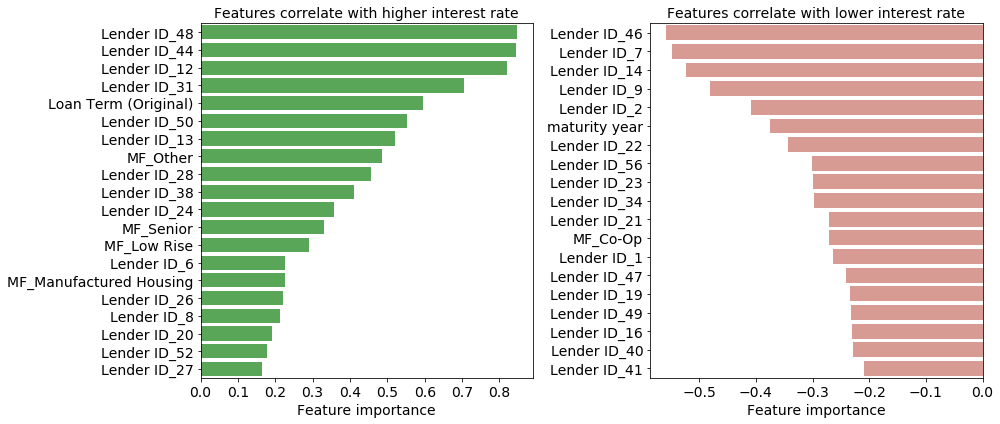

In [27]:
# Visualize feature importance
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.barplot(x="importance", y="variable", data=feature_importance.iloc[:20, :],
               color="limegreen", saturation=.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Feature importance', fontsize=14)
plt.title('Features correlate with higher interest rate', fontsize=14)

plt.subplot(122)
sns.barplot(x="importance", y="variable", data=feature_importance.iloc[-1:-20:-1, :],
               color="salmon", saturation=.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Feature importance', fontsize=14)
plt.title('Features correlate with lower interest rate', fontsize=14)

plt.tight_layout()

Therefore, certian lenders and loan term correlate strongly with higher interst rate.